**Importing general dependencies**

In [9]:
import pandas as pd
import networkx
from networkx.algorithms.components.connected import connected_components
import re
import glob
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import time
import subprocess
import arrow
from collections import defaultdict
import natsort
from collections import Counter
import pickle
%matplotlib inline
date = arrow.now().format('YYMMDD')

**Obtaining `master_df` from notebook cyanobiome-genomics | mash-taxonomy**

In [10]:
summary_df = pd.read_csv("/home/tiago/Desktop/cyanet/cyanobiome/tables/master_df-TFL190425-taxaID.txt",sep="\t")

summary_df = summary_df.reset_index(drop=True)

summary_df[:5]

,collectionID,genomeID,completeness,#scaffolds,GC,#fragBGCs,#completeBGCs,#allBGCs,MASH-taxa
0,ASG15JUL146CUL,SIO3F2,99.09,454,49.40,10,0,10,Spirulina
1,ASX22JUL142CUL,SIO1E4,99.73,659,52.29,12,18,30,Leptolyngbya
2,CobbledownCUL,SIO4C1,99.18,849,53.63,21,4,25,Leptolyngbya
3,numC11CUL,SIO4C4,94.38,1496,46.66,4,2,6,Kamptonema
4,numC15BCUL,SIO4C5,98.64,1204,52.29,15,0,15,Leptolyngbya


**Visualizing counts per genera**

In [11]:
len(summary_df[summary_df.collectionID.str.contains("CUL")])

13

In [12]:
c = Counter(list(summary_df["MASH-taxa"]))

print len(list(summary_df["MASH-taxa"]))

c

75


Counter({'Cyanothece': 2,
         'Desertifilum': 1,
         'Kamptonema': 2,
         'Leptolyngbya': 6,
         'Merismopedia': 1,
         'Microcoleus': 1,
         'Moorea': 24,
         'Okeania': 22,
         'Oscillatoria': 1,
         'Sphaerospermopsis': 2,
         'Spirulina': 1,
         'Symploca': 12})

In [13]:
mash_categories_df = summary_df[summary_df["MASH-taxa"].isin(['Moorea'])]

genomeIDs = list(mash_categories_df.genomeID)

assert(len(list(mash_categories_df["MASH-taxa"])) == len(genomeIDs))

len(genomeIDs)

24

**Importing gene cluster network and generating gene cluster families (522 strains)**

In [14]:
affinity_df = pd.read_csv("./cyanobiome/tables/affinity_df-TFL190403.txt",sep=",",index_col=0)

with open("./cyanobiome/tables/affinity_bgcs-TFL190403.txt", "rb") as fp:
    affinity_bgcs = pickle.load(fp)

In [15]:
affinity_df.shape,len(affinity_bgcs)

((4539, 523), 5945)

In [16]:
#removing MIBIG BGCs
affinity_bgcs_2 = []

for item in affinity_bgcs:
    if not item.startswith("BGC"):
        affinity_bgcs_2.append(item)

## Creating `subset_df`

In [17]:
genomeID_list = []

for item in genomeIDs:
    item = item[3:]
    if item in affinity_df.columns:
        genomeID_list.append(item)
        
genomeID_list.append("label")
genomeID_list.append("bgc")

affinity_df["bgc"] = affinity_bgcs_2

subset_df = affinity_df[genomeID_list]

index_to_keep = []

for i,r in subset_df.iterrows():
    if subset_df.bgc.loc[i].split("_")[0] in genomeID_list:
        index_to_keep.append(i)
        
print len(index_to_keep)

subset_df = subset_df.iloc[index_to_keep]

575


In [18]:
subset_df.shape

(575, 26)

In [22]:
len(np.unique(subset_df.label))

33

## Averaging family similarity in `heatmap_df`

In [47]:
family_size_list = []
family_codes = []
heatmap_df = pd.DataFrame()

for family in np.unique(list(subset_df.label)):
    family_set = subset_df[subset_df.label == family]
    if family not in family_codes:
        family_codes.append(family)
    family_set = family_set.drop(columns=["bgc","label"],axis=1,inplace=False)
    family_size = len(family_set)
    family_size_list.append(family_size)
    heatmap_df = heatmap_df.append(family_set.mean(), ignore_index=True)

In [48]:
heatmap_df.shape, len(family_codes)

((33, 24), 33)

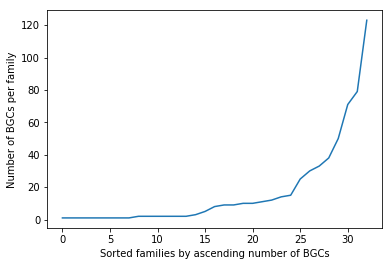

In [49]:
import matplotlib.pyplot as plt

plt.plot(sorted(family_size_list))
plt.xlabel('Sorted families by ascending number of BGCs')
plt.ylabel('Number of BGCs per family')
plt.show()

In [50]:
heatmap_df["gcf"] = family_codes

for item in family_codes:
    num = len(subset_df[subset_df.label == item])
    if num > np.average(family_size_list):
        print item, num

GCF10 33
GCF11 79
GCF12 71
GCF3 50
GCF36 30
GCF4 123
GCF56 25
GCF9 38


In [58]:
subset_df[subset_df.label == "GCF9"]

,3F7,1F2,4G2,4G3,3A5,2B7,2C4,2I5,4E2,3B2,...,4A1,4A3,3G5,4A5,1G6,3A2,3C2,ASIH,label,bgc
435,0.000000,0.226523,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.649275,0.000000,0.000000,1.000000,0.351238,0.324289,0.000000,0.496640,GCF9,4A5_002
438,0.535895,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GCF9,4A3_035
441,0.000000,0.385392,0.0,0.000000,0.387191,0.000000,0.0,0.0,0.287614,0.000000,...,0.000000,0.000000,0.265833,0.324289,0.822104,1.000000,0.000000,0.410275,GCF9,3A2_015
443,0.000000,0.000000,0.0,0.000000,1.000000,0.260235,0.0,0.0,0.780376,0.456144,...,0.000000,0.462775,0.000000,0.000000,0.431762,0.999190,0.000000,0.000000,GCF9,3A5_008
444,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.208259,0.000000,...,1.000000,0.000000,0.217730,0.649275,0.000000,0.000000,0.000000,0.365486,GCF9,4A1_012
450,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.429768,...,0.000000,0.246283,0.000000,0.000000,0.201428,0.000000,1.000000,0.000000,GCF9,3C2_018
452,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GCF9,3G5_027
454,0.000000,0.000000,0.0,0.000000,0.480193,0.383157,0.0,0.0,0.387130,0.521415,...,0.000000,0.896207,0.000000,0.000000,0.331712,0.480193,0.000000,0.000000,GCF9,3I8_019
456,0.000000,0.000000,0.0,0.000000,0.780376,0.227257,0.0,0.0,1.000000,0.367130,...,0.000000,0.391117,0.000000,0.000000,0.417063,0.781029,0.000000,0.000000,GCF9,4E2_001
457,0.000000,0.403558,0.0,0.000000,0.365714,0.000000,0.0,0.0,0.444999,0.000000,...,0.331182,0.000000,0.465756,0.222382,0.213942,0.200106,0.000000,0.214932,GCF9,3I8_016


In [52]:
heatmap_df

,1F2,1G6,2B7,2C4,2I5,3A2,3A5,3B2,3C2,3E2,...,3I7,3I8,4A1,4A3,4A5,4E2,4G2,4G3,ASIH,gcf
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,GCF1
1,0.444473,0.487657,0.000000,0.243129,0.247801,0.513784,0.513471,0.355592,0.133344,0.000000,...,0.030303,0.479892,0.167973,0.000000,0.259734,0.500806,0.000000,0.401045,0.531753,GCF10
2,0.629938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.629938,0.000000,GCF101
3,0.502543,0.633008,0.000000,0.000000,0.000000,0.593054,0.550591,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332280,GCF102
4,0.053145,0.374540,0.322019,0.365807,0.297608,0.135435,0.143432,0.261437,0.377062,0.286089,...,0.217366,0.090044,0.103220,0.414100,0.000000,0.456384,0.000000,0.471034,0.139869,GCF11
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,GCF114
6,0.107575,0.045006,0.103027,0.000000,0.079696,0.232988,0.288852,0.064585,0.041405,0.000000,...,0.000000,0.058499,0.164030,0.109520,0.131993,0.130343,0.083586,0.294637,0.327089,GCF12
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,GCF137
8,0.739841,0.489338,0.000000,0.392699,0.000000,0.775074,0.775074,0.624110,0.000000,0.000000,...,0.000000,0.739614,0.736895,0.000000,0.705712,0.000000,0.000000,0.000000,0.722780,GCF209
9,0.000000,0.000000,0.000000,0.000000,0.706430,0.000000,0.000000,0.709419,0.563928,0.000000,...,0.716418,0.797964,0.798042,0.000000,0.798042,0.000000,0.000000,0.444640,0.000000,GCF22


In [17]:
sum(family_size_list)

252

In [38]:
supercount = 0
unique_count = 0

for item in family_size_list:
    if item > np.average(family_size_list):
        supercount += item
    if item == 1:
        unique_count += 1

print(np.average(family_size_list),float(float(supercount)/float(sum(family_size_list)))),unique_count

(17.424242424242426, 0.7808695652173913) 8


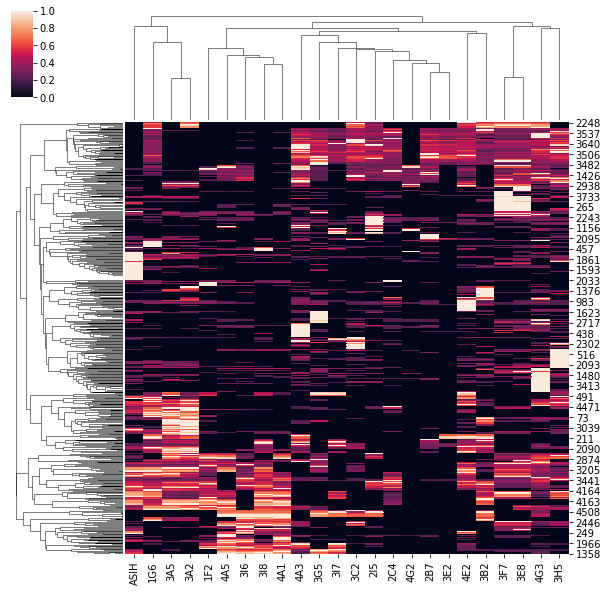

In [39]:
subset_df2 = subset_df.drop(columns=["bgc","label"],axis=1)

sns.clustermap(subset_df2)

In [ ]:
sns.clustermap(heatmap_df,row_cluster=True)

In [40]:
new_names = []

for item in heatmap_df.columns:
    if item != "gcf":
        new_names.append("SIO"+item)
        
col_rename_dict = {i:j for i,j in zip(heatmap_df.columns,new_names)}

col_rename_dict

heatmap_df.rename(columns=col_rename_dict, inplace=True)

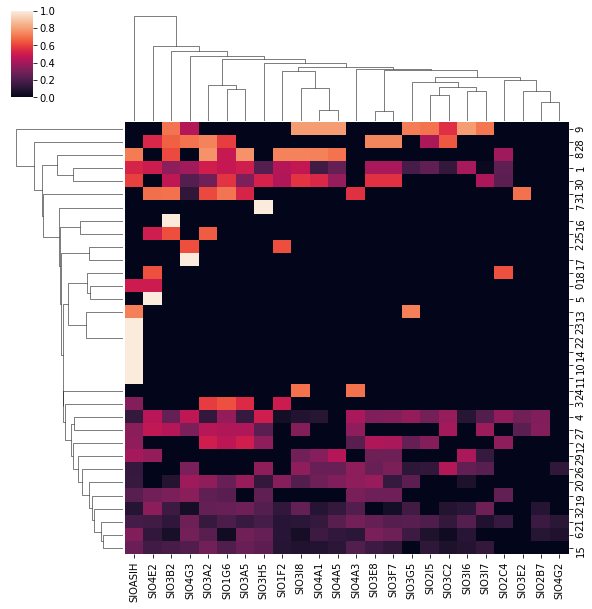

In [43]:
sns.clustermap(heatmap_df,row_cluster=True)

**Testing CORASON**

In [55]:
!mkdir -p ./bigscape/corason/inputs

In [56]:
gcf3_df = subset_df[subset_df.label == "GCF3"]

for item in gcf3_df.bgc:
    bgc_path = glob.glob("/home/tiago/Desktop/cyanet/bigscape/all_bgcs/%s.gbk"%item)
    if bgc_path:
        subprocess.call("cp %s /home/tiago/Desktop/cyanet/bigscape/corason/inputs/"%bgc_path[0],shell=True)

In [57]:
!ls ./bigscape/corason/inputs/*gbk | wc -l

35


```
Copied to gerwick-lab:Desktop/

$ mkdir ~/bin # not required if you already have that 
$ curl -q https://raw.githubusercontent.com/nselem/corason/master/run_corason > ~/bin/run_corason 
$ chmod a+x ~/bin/run_corason 
$ ~/bin/run_corason

$ cd ~/Desktop/corason/
$ ~/bin/run_corason curM.fasta inputs inputs/curA.gbk
```

`Checking the aligment, we decided to subset the inputs into folder pnas-inputs. 
Additionally, we are going to add two patched curacin pathways`

In [10]:
!mkdir ./pnas-curacin/
!cp ./bigscape/all_bgcs/2H1_034.gbk ./pnas-curacin/
!cp ./bigscape/all_bgcs/2H1_013.gbk ./pnas-curacin/
!cp ./bigscape/all_bgcs/3H5_003.gbk ./pnas-curacin/
!cp ./bigscape/all_bgcs/3H5_028.gbk ./pnas-curacin/
!cp /home/gerwick-lab/Desktop/corason/pnas-inputs/curA.gbk ./pnas-curacin/

In [11]:
from Bio import SeqIO

def gbk_to_fasta(gbk_filename,fna_filename):
    input_handle  = open(gbk_filename, "r")
    output_handle = open(fna_filename, "w")
    for seq_record in SeqIO.parse(input_handle, "genbank") :
        print "Processing record %s" % seq_record.id
        output_handle.write(">%s %s\n%s\n" % (
               seq_record.id,
               seq_record.description,
               seq_record.seq))
    output_handle.close()
    input_handle.close()
    
gbk_to_fasta("./pnas-curacin/2H1_013.gbk","./pnas-curacin/2H1_013.fasta")
gbk_to_fasta("./pnas-curacin/2H1_034.gbk","./pnas-curacin/2H1_034.fasta")
gbk_to_fasta("./pnas-curacin/3H5_003.gbk","./pnas-curacin/3H5_003.fasta")
gbk_to_fasta("./pnas-curacin/3H5_028.gbk","./pnas-curacin/3H5_028.fasta")
gbk_to_fasta("./pnas-curacin/curA.gbk","./pnas-curacin/curA.fasta")

Processing record 2H1_013
Processing record 2H1_034
Processing record 3H5_003
Processing record 3H5_028
Processing record BGC0000976.1


In [16]:
!cat ./pnas-curacin/2H1_013.fasta ./pnas-curacin/2H1_034.fasta > ./pnas-curacin/cur_2H1.fasta
!cat ./pnas-curacin/3H5_003.fasta ./pnas-curacin/3H5_028.fasta > ./pnas-curacin/cur_3H5.fasta

In [18]:
!mkdir ./pnas-curacin/reference/
!mv ./pnas-curacin/curA.fasta ./pnas-curacin/reference/

In [19]:
!mkdir ./pnas-curacin/outputs
ref_folder = "/home/tiago/Desktop/cyanet/pnas-curacin/reference/"

commands = []

file1 = "/home/tiago/Desktop/cyanet/pnas-curacin/cur_2H1.fasta"
file2 = "/home/tiago/Desktop/cyanet/pnas-curacin/cur_3H5.fasta"
out1 = "/home/tiago/Desktop/cyanet/pnas-curacin/cur_2H1_scaffold.fasta"
out2 = "/home/tiago/Desktop/cyanet/pnas-curacin/cur_3H5_scaffold.fasta"

commands.append("java -jar medusa.jar -f %s -i %s -d -v -o %s"%(ref_folder,file1,out1))
commands.append("java -jar medusa.jar -f %s -i %s -d -v -o %s"%(ref_folder,file2,out2))

commands

# for concat_file in contigs_list:
#         out_scaffold = os.path.join(outdir,
#                                     os.path.basename(concat_file).split(".fasta")[0]+"_scaffold.fasta")
#         commands.append("java -jar medusa.jar -f %s -i %s -d -v -o %s"%(ref_folder,concat_file,out_scaffold))
        
# with open('./wp2-dev/medusa/run_cur_medusa.txt', 'w') as f:
#     for item in commands:
#         f.write("%s\n" % item)

['java -jar medusa.jar -f /home/tiago/Desktop/cyanet/pnas-curacin/reference/ -i /home/tiago/Desktop/cyanet/pnas-curacin/cur_2H1.fasta -d -v -o /home/tiago/Desktop/cyanet/pnas-curacin/cur_2H1_scaffold.fasta',
 'java -jar medusa.jar -f /home/tiago/Desktop/cyanet/pnas-curacin/reference/ -i /home/tiago/Desktop/cyanet/pnas-curacin/cur_3H5.fasta -d -v -o /home/tiago/Desktop/cyanet/pnas-curacin/cur_3H5_scaffold.fasta']

`Offline version presented a bug (analysis taking too long). Samples were submitted to medusa online, followed by antiSMASH`

`~/bin/run_corason curM.fasta pnas-inputs pnas-inputs/curA.gbk`